In [1]:
import os
from pathlib import Path

# 方法 1：相對於 notebook 位置
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent  # 從 model/aapl 往上兩層
os.chdir(project_root)

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import numpy as np
import ta

In [3]:
df = pd.read_csv("data/2330_TW.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[23:]
df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
stoch = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close'], window=14)
df['k'] = stoch.stoch()
df['d'] = stoch.stoch_signal()
df

,Close,High,Low,Open,Volume,rsi,k,d
Date,,,,,,,,
2014-01-03,73.997704,74.358668,73.636739,74.358668,38599000,NaN,NaN,NaN
2014-01-06,73.997704,74.358668,73.636739,73.636739,23706000,NaN,NaN,NaN
2014-01-07,73.636726,74.358655,73.636726,73.997691,15836000,NaN,NaN,NaN
2014-01-08,75.080612,75.441577,73.997719,74.358683,30218000,NaN,NaN,NaN
2014-01-09,72.914787,74.358644,72.553823,73.997680,63998000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-12-25,564.011108,567.894145,563.040349,564.981868,9548143,58.299930,71.936110,67.926818
2023-12-26,568.864929,568.864929,564.981892,565.952651,16094308,62.416420,91.982151,79.954442
2023-12-27,574.689453,574.689453,568.864898,569.835657,33401336,66.668544,100.000000,87.972754


In [4]:
from sklearn.preprocessing import MinMaxScaler

def preprocess(data_trend, train_ratio, n_past, predict_day):
    scaler = MinMaxScaler()  
    print(data_trend.shape)
    data_trend = scaler.fit_transform(data_trend)
    
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data = df[[c for c in df.columns if c not in ['Date','Adj Close','Volume','rsi','k','d']]].values
train_ratio = 0.9
test_val_ratio = 0.9
n_past = 40     #移動視窗大小
predict_day = 5 #要預測後面幾天
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = preprocess(data, train_ratio, n_past, predict_day)
batch_size = 32

print(Y_train.shape)
train_set = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

val_set = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
X_train.shape[2]

(2439, 4)
torch.Size([1935, 5, 4])


4

In [5]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # 建立一個位置編碼矩陣
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶數位置
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇數位置
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x 的形狀為 (seq_length, batch_size, d_model)
        x = x + self.pe[:x.size(0)]
        return x

In [6]:
class TransformerTimeSeries(nn.Module):
    def __init__(self, feature_size, num_layers=2, nhead=4, hidden_dim=128, dropout=0.1):
        super(TransformerTimeSeries, self).__init__()
        self.model_type = 'Transformer'
        self.input_linear = nn.Linear(feature_size, hidden_dim)  # 新增的線性層
        self.pos_encoder = PositionalEncoding(d_model=hidden_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.decoder = nn.Linear(hidden_dim, feature_size)
        self.hidden_dim = hidden_dim

    def forward(self, src):
        # src 形狀: (seq_length, batch_size, feature_size)
        src = src.permute(1, 0, 2)
        src = self.input_linear(src)  # 將輸入映射到 hidden_dim 維度
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        
        output = output[-5:, :, :]  # 取最後 5 個時間步
        output = self.decoder(output)  # 映射到 feature_size
        output = output.permute(1, 0, 2)
        return output

In [7]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# 檢查是否有可用的GPU
if torch.cuda.is_available():
    print("GPU")
    device = torch.device("cuda")  # 使用GPU
else:
    print("CPU")
    device = torch.device("cpu")  # 使用CPU
# 設置訓練參數
num_epochs = 100
learning_rate = 1e-4

feature_size = 4  # 輸入特徵數
num_layers = 2
nhead = 4
hidden_dim = 128

model = TransformerTimeSeries(feature_size=feature_size, num_layers=num_layers, nhead=nhead, hidden_dim=hidden_dim).to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

GPU


c:\Users\N98141062\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [8]:
# 記錄每個 epoch 的損失值
train_losses = []
val_losses = []
min_loss = 100
min_val_loss = float('inf')
best_model_path = "output/model/2330tw/transformer_5.pth"

# 訓練模型
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # print(f"x_batch shape: {x_batch.shape}, y_batch shape: {y_batch.shape}")
        x_batch= x_batch.to(device)
        # print(x_batch.shape)
        y_batch= y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch).squeeze(-1)
        # print(outputs.shape)
        # print(y_batch.shape)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # 驗證模型
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch= x_batch.to(device)
            y_batch= y_batch.to(device)
            outputs = model(x_batch).squeeze(-1)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model, best_model_path) 
        print(f"Model saved with val_loss: {val_loss:.4f}")
    
    # 打印每個epoch的訓練和驗證損失
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Model saved with val_loss: 0.0614
Epoch [1/100], Train Loss: 0.0306, Val Loss: 0.0614
Model saved with val_loss: 0.0130
Epoch [2/100], Train Loss: 0.0945, Val Loss: 0.0130
Model saved with val_loss: 0.0033
Epoch [3/100], Train Loss: 0.0318, Val Loss: 0.0033
Model saved with val_loss: 0.0022
Epoch [4/100], Train Loss: 0.0104, Val Loss: 0.0022
Model saved with val_loss: 0.0020
Epoch [5/100], Train Loss: 0.0089, Val Loss: 0.0020
Model saved with val_loss: 0.0016
Epoch [6/100], Train Loss: 0.0081, Val Loss: 0.0016
Epoch [7/100], Train Loss: 0.0078, Val Loss: 0.0017
Model saved with val_loss: 0.0016
Epoch [8/100], Train Loss: 0.0071, Val Loss: 0.0016
Model saved with val_loss: 0.0015
Epoch [9/100], Train Loss: 0.0069, Val Loss: 0.0015
Epoch [10/100], Train Loss: 0.0068, Val Loss: 0.0016
Epoch [11/100], Train Loss: 0.0070, Val Loss: 0.0020
Epoch [12/100], Train Loss: 0.0074, Val Loss: 0.0025
Epoch [13/100], Train Loss: 0.0078, Val Loss: 0.0049
Epoch [14/100], Train Loss: 0.0079, Val Loss: 0.

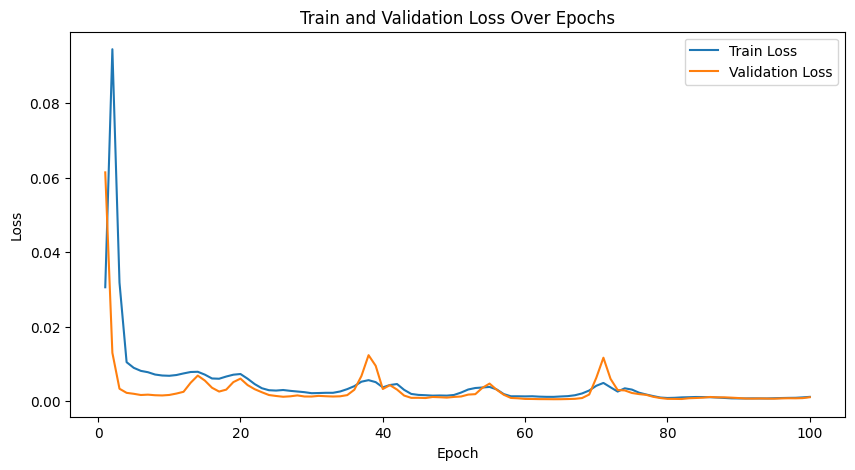

In [9]:
import matplotlib.pyplot as plt
# 繪製損失走勢圖
plt.figure(figsize=(10, 5))
plt.plot(range(1, 100+1), train_losses, label='Train Loss')
plt.plot(range(1, 100+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Over Epochs')
plt.show()

C:\Users\N98141062\AppData\Local\Temp\ipykernel_17764\365793335.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('output/model/2330tw/transformer_5.pth

MAE:  10.3921
RMSE: 12.5890
MAPE: 1.9778%
R²:   0.7704


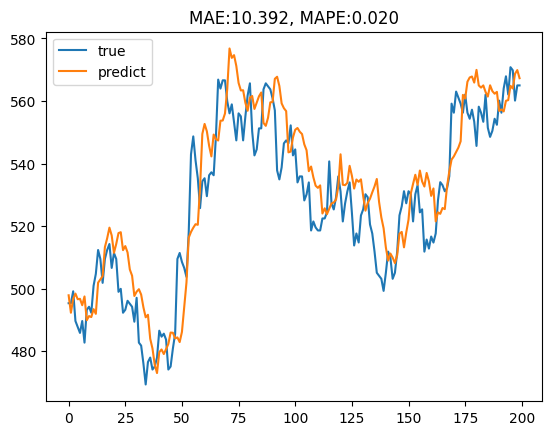

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
close_price_true = []
close_price_pred = []
model = torch.load('output/model/2330tw/transformer_5.pth')
model.to(device)

dim = 3
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device)).squeeze(-1)
    # print(pred)
    # print(scaler.inverse_transform(torch.squeeze(pred.detach().cpu())))
    y=torch.squeeze(y)
    # print(scaler.inverse_transform(y)[0,dim])
    close_price_true.append(scaler.inverse_transform(y)[0,dim])
    close_price_pred.append(scaler.inverse_transform(torch.squeeze(pred.detach().cpu()))[0,dim])

mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
# 新增：RMSE
rmse = np.sqrt(np.mean((np.array(close_price_true) - np.array(close_price_pred)) ** 2))
# 新增：R²
r2 = r2_score(close_price_true, close_price_pred)
plt.plot(close_price_true)
plt.plot(close_price_pred)
plt.title('MAE:{:.3f}, MAPE:{:.3f}'.format(mae, mape))
plt.legend(['true', 'predict'])
# 輸出所有指標
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R²:   {r2:.4f}")

In [11]:
btdf = pd.DataFrame({'close':close_price_true, 'rsi':df['rsi'][-204:-4],'predicted_close':close_price_pred})

In [12]:
btdf =btdf.dropna().reset_index(drop=True)

In [13]:
btdf

,close,rsi,predicted_close
0,495.333975,54.665447,497.861465
1,495.333908,52.878740,492.284736
2,499.136932,53.425225,496.722449
3,489.629574,48.027092,498.407162
4,487.728063,49.846199,496.597670
...,...,...,...
195,570.806306,65.586338,564.862404
196,569.835555,65.586338,564.002911
197,560.128048,55.190730,568.694352
198,564.981801,59.510359,569.882641


買入價格: 499.1369316315785
賣出價格: 489.62957447994
cash: 980956.7636252682
額外要扣掉: 4294.298533603909
扣掉後的: 976662.4650916643
-------------------------------------
買入價格: 487.7280626899514
賣出價格: 494.1903843262602
cash: 989600.0330075546
額外要扣掉: 4286.324109302719
扣掉後的: 985313.7088982519
-------------------------------------
買入價格: 500.88161250594163
賣出價格: 504.7050513477212
cash: 992834.4131000324
額外要扣掉: 4308.112693497604
扣掉後的: 988526.3004065348
-------------------------------------
買入價格: 509.4845096569368
賣出價格: 477.94030679424907
cash: 927330.5468529207
額外要扣掉: 4121.0918276241055
扣掉後的: 923209.4550252965
-------------------------------------
買入價格: 486.54330484439646
賣出價格: 484.6316358730828
cash: 919583.0189867145
額外要扣掉: 4005.3538039471878
扣掉後的: 915577.6651827673
-------------------------------------
買入價格: 475.07275288770245
賣出價格: 509.4845096569368
cash: 981889.1204770819
額外要扣掉: 4176.723850280908
扣掉後的: 977712.396626801
-------------------------------------
買入價格: 518.0874404409827
賣出價格: 548.675522937

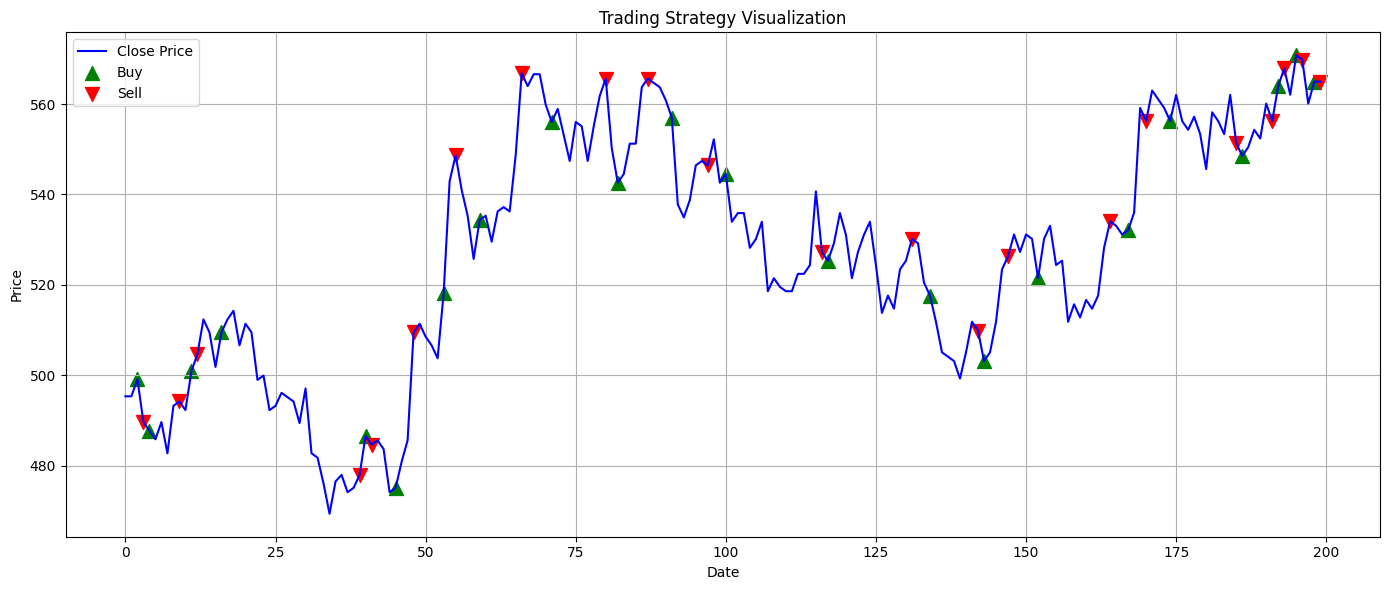

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# 初始化參數
initial_cash = 1000000
in_position = False
entry_price = 0
shares = 0
cash = initial_cash

# 儲存交易點資訊
buy_dates = []
buy_prices = []
sell_dates = []
sell_prices = []

# 手續費和稅率
fee_rate = 0.001425  # 手續費率 (1.425‰)
tax_rate = 0.0015     # 證券交易稅率 (1‰)
need_pay = 0 #需要付的手續費+稅金

# 模擬交易
for i in range(1, len(btdf)):
    if not in_position:
        need_pay = 0
        if btdf.loc[i, 'predicted_close'] > btdf.loc[i - 1, 'close']:
            entry_price = btdf.loc[i, 'close']
            shares = cash // entry_price
            need_pay += cash * fee_rate
            cash -= shares * entry_price
            in_position = True

            buy_dates.append(btdf.index[i])
            buy_prices.append(entry_price)

            print('買入價格:', entry_price)

    else:
        if btdf.loc[i, 'predicted_close'] < btdf.loc[i - 1, 'close']:
            exit_price = btdf.loc[i, 'close']
            cash += shares * exit_price
            need_pay += cash * (fee_rate + tax_rate)
            shares = 0
            in_position = False

            sell_dates.append(btdf.index[i])
            sell_prices.append(exit_price)

            print('賣出價格:', exit_price)
            print('cash:', cash)
            print('額外要扣掉:', need_pay)
            cash -= need_pay
            print('扣掉後的:', cash)
            print('-------------------------------------')

# 最後一天強制平倉
if in_position:
    final_price = btdf.loc[len(btdf) - 1, 'close']
    cash += shares * final_price
    sell_dates.append(btdf.index[-1])
    sell_prices.append(final_price)
    print('賣出價格:', final_price)

# 顯示最終資金
print('最終價格:', cash)

# 繪圖
plt.figure(figsize=(14, 6))
plt.plot(btdf.index, btdf['close'], label='Close Price', color='blue')

# 標記買進與賣出點
plt.scatter(buy_dates, buy_prices, color='green', label='Buy', marker='^', s=100)
plt.scatter(sell_dates, sell_prices, color='red', label='Sell', marker='v', s=100)

plt.title('Trading Strategy Visualization')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


買入價格: 499.1369316315785
賣出價格: 548.6755229370822
cash: 1099225.798384924
額外要扣掉: 4640.235460275902
扣掉後的: 1094585.562924648
-------------------------------------
買入價格: 534.3373834407907
賣出價格: 564.9818685629901
最終價格: 1157345.4684549123


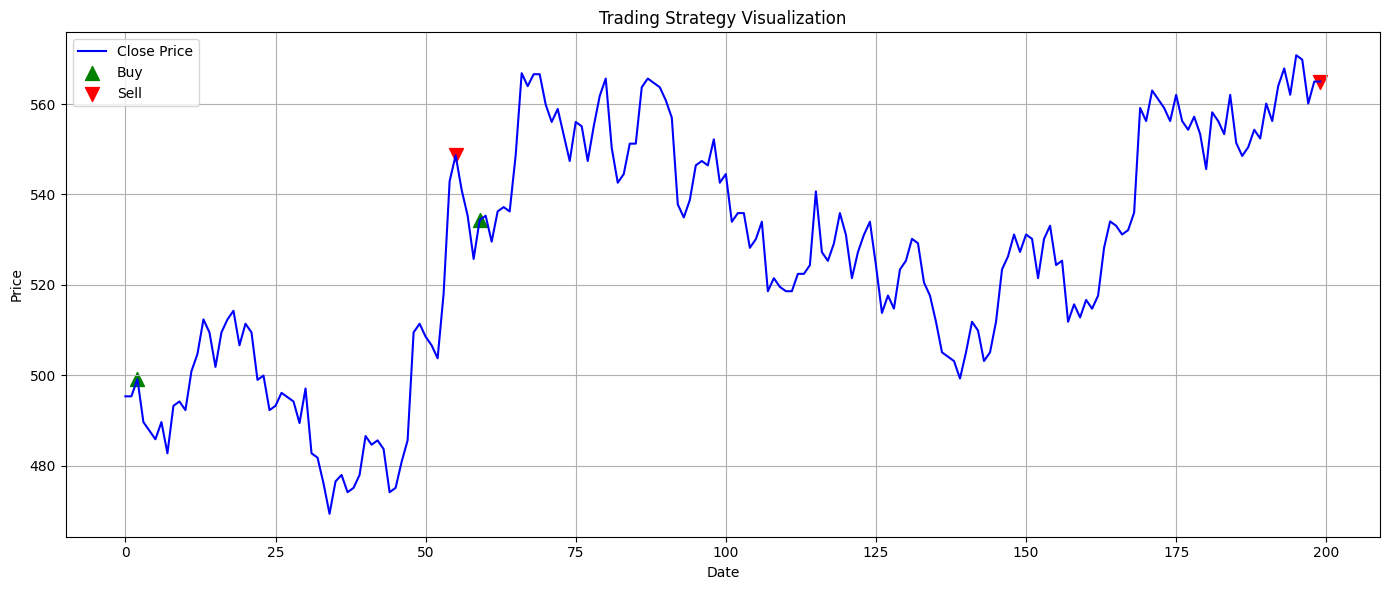

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# 初始化參數
initial_cash = 1000000
in_position = False
entry_price = 0
shares = 0
cash = initial_cash

# 儲存交易點資訊
buy_dates = []
buy_prices = []
sell_dates = []
sell_prices = []

# 手續費和稅率
fee_rate = 0.001425  # 手續費率 (1.425‰)
tax_rate = 0.0015     # 證券交易稅率 (1.5‰)
need_pay = 0 #需要付的手續費+稅金

# 模擬交易
for i in range(1, len(btdf)):
    if not in_position:
        need_pay = 0
        if btdf.loc[i, 'predicted_close'] > btdf.loc[i - 1, 'close']:
            entry_price = btdf.loc[i, 'close']
            shares = cash // entry_price
            need_pay += cash * fee_rate
            cash -= shares * entry_price
            in_position = True

            buy_dates.append(btdf.index[i])
            buy_prices.append(entry_price)

            print('買入價格:', entry_price)

    else:
        if btdf.loc[i, 'rsi'] > 75.704 and btdf.loc[i, 'predicted_close'] < btdf.loc[i - 1, 'close']:
            exit_price = btdf.loc[i, 'close']
            cash += shares * exit_price
            need_pay += cash * (fee_rate + tax_rate)
            shares = 0
            in_position = False

            sell_dates.append(btdf.index[i])
            sell_prices.append(exit_price)

            print('賣出價格:', exit_price)
            print('cash:', cash)
            print('額外要扣掉:', need_pay)
            cash -= need_pay
            print('扣掉後的:', cash)
            print('-------------------------------------')

# 最後一天強制平倉
if in_position:
    final_price = btdf.loc[len(btdf) - 1, 'close']
    cash += shares * final_price
    sell_dates.append(btdf.index[-1])
    sell_prices.append(final_price)
    print('賣出價格:', final_price)

# 顯示最終資金
print('最終價格:', cash)

# 繪圖
plt.figure(figsize=(14, 6))
plt.plot(btdf.index, btdf['close'], label='Close Price', color='blue')

# 標記買進與賣出點
plt.scatter(buy_dates, buy_prices, color='green', label='Buy', marker='^', s=100)
plt.scatter(sell_dates, sell_prices, color='red', label='Sell', marker='v', s=100)

plt.title('Trading Strategy Visualization')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
close_price_true = []
close_price_pred = []

dim = 3
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device))
    # print(pred)
    # print(scaler.inverse_transform(torch.squeeze(pred.detach().cpu())))
    y=torch.squeeze(y)
    # print(scaler.inverse_transform(y)[:,dim])
    close_price_true.append(scaler.inverse_transform(y)[:,dim])
    close_price_pred.append(scaler.inverse_transform(torch.squeeze(pred.detach().cpu()))[:,dim])

print(np.array(close_price_true).shape)
print(np.array(close_price_pred).shape)
mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
# 新增：RMSE
rmse = np.sqrt(np.mean((np.array(close_price_true) - np.array(close_price_pred)) ** 2))
# 新增：R²
r2 = r2_score(close_price_true, close_price_pred)
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R²:   {r2:.4f}")

(200, 5)
(200, 5)
MAE:  11.1998
RMSE: 13.6340
MAPE: 2.1329%
R²:   0.7338


In [17]:
close_price_pred

[array([497.86146545, 488.82295302, 502.26319096, 503.38468504,
        498.44805949]),
 array([492.28473567, 493.55976462, 504.56379253, 502.7551416 ,
        499.95902429]),
 array([496.72244855, 495.24599126, 503.14276251, 503.45598711,
        498.22809933]),
 array([498.4071617 , 493.94018806, 503.79144316, 501.7626639 ,
        500.51605488]),
 array([496.59766993, 493.65726684, 500.88847365, 502.65451151,
        491.06974171]),
 array([496.7324712 , 491.10922691, 501.95393506, 493.4273513 ,
        489.65089783]),
 array([494.68623639, 492.80345821, 493.29063295, 492.38862816,
        487.21983366]),
 array([497.49651321, 485.3978304 , 493.37172224, 491.06896815,
        489.10896849]),
 array([489.87502848, 485.51494068, 492.07607622, 492.93883124,
        486.13469691]),
 array([491.21429656, 485.34122598, 495.02572841, 491.34533093,
        495.51276862]),
 array([490.90103833, 488.09721905, 493.18135917, 500.36763222,
        496.39832684]),
 array([493.43195903, 485.928795

In [18]:
close_price_true = []
close_price_pred = []

dim = 3
for i in range(len(test_set)):
    x, y = test_set[i]
    x = torch.unsqueeze(x, 0)
    y = torch.unsqueeze(y, 0)
    pred = model(x.to(device))
    
    # 取第十天的真實值和預測值
    y_tenth_day = torch.squeeze(y)[4]  # 第 5 天對應索引為 4
    pred_tenth_day = torch.squeeze(pred.detach().cpu())[4]
    
    # 反轉換
    true_tenth_day = scaler.inverse_transform(y_tenth_day.unsqueeze(0))[:, dim]
    pred_tenth_day = scaler.inverse_transform(pred_tenth_day.unsqueeze(0))[:, dim]
    
    # 儲存第十天的值
    close_price_true.append(true_tenth_day)
    close_price_pred.append(pred_tenth_day)

# 將結果轉換為 NumPy 陣列
close_price_true = np.array(close_price_true).squeeze()
close_price_pred = np.array(close_price_pred).squeeze()

print(np.array(close_price_true).shape)
print(np.array(close_price_pred).shape)

# 計算 MAE 和 MAPE
mape = np.mean(np.abs(close_price_true - close_price_pred) / close_price_true)
mae = np.mean(np.abs(close_price_true - close_price_pred))

print("第五天的 mape: ", mape)
print("第五天的 mae: ", mae)


(200,)
(200,)
第五天的 mape:  0.022268842216713446
第五天的 mae:  11.694994385241307


In [19]:
close_price_pred[1]

np.float64(499.95902429094656)

In [ ]:
import csv

with open('output/2330tw_output.csv', mode='r', newline='') as file:
    reader = csv.reader(file)
    rows = list(reader)

for i in range(len(close_price_pred)):
    rows[i].append(close_price_pred[i].item())

# 寫回檔案
with open('output/2330tw_output.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)